In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import os
import sys
import torch
import time
import seaborn as sns
from sklearn.metrics.pairwise import linear_kernel
from scipy.linalg import svd

from sklearn.metrics.pairwise import linear_kernel

# X 和 Y 的维度可以不一样
sys.path.insert(0,os.path.abspath('/notebooks/4901_revisit_cdtran'))
sys.path.insert(0,os.path.abspath('/notebooks/pytorchtimseries'))
from tqdm.notebook import tqdm


def xy_plot(x, y, pred_y, title=None, y_label=None):
    with plt.style.context(['ieee', 'notebook']):

        fig, ax = plt.subplots()
        
        x_ticks = np.arange(len(x))
        y_ticks = np.arange(len(x), len(x)+len(y))
        
        # 设置边框粗度
        for spine in ax.spines.values():
            spine.set_linewidth(2)  # 设置边框粗度为2

        
        ax.plot(x_ticks, x, label='lookback', linewidth=3)
        ax.plot(y_ticks, y, label='ground_truth', linewidth=3)
        ax.plot(y_ticks, pred_y, label='prediction', linewidth=3)
    if y_label: plt.ylabel(y_label)
    if title: plt.title(title)
    plt.legend()
    
# X 和 Y 的维度可以不一样
# K = linear_kernel(X, X)  # K: n x n
# L = linear_kernel(Y, Y)  # L: n x n

def center_kernel(K):
    n = K.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    return H @ K @ H

def compute_cka(X, Y):
    K = linear_kernel(X, X)
    L = linear_kernel(Y, Y)
    
    K_c = center_kernel(K)
    L_c = center_kernel(L)
    
    hsic = np.trace(K_c @ L_c)
    norm_k = np.trace(K_c @ K_c)
    norm_l = np.trace(L_c @ L_c)
    
    return hsic / np.sqrt(norm_k * norm_l)

def standardize(X):
    mean_vals = X.mean(axis=1, keepdims=True)
    std_vals = X.std(axis=1, keepdims=True)
    return (X - mean_vals) / (std_vals + 1e-8)  # 避免除以零


In [2]:
from src.experiments.shortterm.PAN import PANForecast
dataset = "PEMS07"
exp = PANForecast(dataset_type=dataset, d_c=256, d_patch=128, patch_len=48, stride=24, windows=96, horizon=1, pred_len=12, data_path='/notebooks/4901_revisit_cdtran/data', save_dir='/notebooks/4901_revisit_cdtran/results', device='cuda:0')
exp._setup_run(1)
exp._resume_run(1)

i = 1020
b = 0
v = 580 #b500
batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: torch.tensor(x).to(exp.device).unsqueeze(0).float(),  exp.dataloader.test_loader.dataset[i])
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)


# batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: x.to(exp.device).float(), next(iter(exp.test_loader)))
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)
plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()


train steps: 19649
val steps: 5633
test steps: 2813


/root/anaconda3/envs/testpyt/lib/python3.8/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/root/anaconda3/envs/testpyt/lib/python3.8/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
/notebooks/pytorchtimseries/torch_timeseries/experiments/forecast.py:378: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped

tensor([128, 224, 320, 416, 512], dtype=torch.int32)
4
self.t_index [47, 71, 95, 119]
not raw_info..
resuming from /notebooks/4901_revisit_cdtran/results/runs/PAN/PEMS07/w96h1s12/2c6f9cf57c9ae858df658957f2f7046a/run_checkpoint.pth


In [65]:
inpe.transpose(0,1).shape

torch.Size([883, 96])

In [81]:
inpe = batch_x[0]
patch_inpe = torch.nn.functional.pad(inpe.transpose(0,1), pad=(24, 0))
patch_inpe = patch_inpe.unfold(dimension=-1, size=24, step=24)
# patch_inpe = inpe.unfold(dimension=-1, size=48, step=2)
# patch_inpe = patch_inpe.reshape(-1, 48)
patch_inpe.shape


torch.Size([883, 5, 24])

In [82]:
patch_inpe = patch_inpe.transpose(1,0).reshape(-1, 24).cpu().detach().numpy()

In [83]:
# tsne = TSNE(n_components=2, random_state=30,perplexity=15)
# low_dim_data = tsne.fit_transform(patch_inpe.cpu().detach().numpy())
# plt.scatter(low_dim_data[:, 0], low_dim_data[:, 1], s=50, edgecolors="k", alpha=0.8)



In [88]:
patch_inpe.shape

(4415, 24)

In [87]:
# selected_stations = [1, 23, 34]
# selected_stations = [1,2,3,4,5,6,7,8,9,10, 11, 23, 34]
# patch_inpe = patch_inpe[selected_stations, :, :]
# patch_inpe = patch_inpe.transpose(1,0).reshape(-1, 48).detach().cpu().numpy()

In [51]:
selected_stations = list(range(len(patch_inpe)))

In [52]:
patch_inpe.shape

(3532, 48)

/tmp/ipykernel_1214492/3328321742.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(norm=norm, cmap="Blues"), label="Metrics")  # 添加颜色条


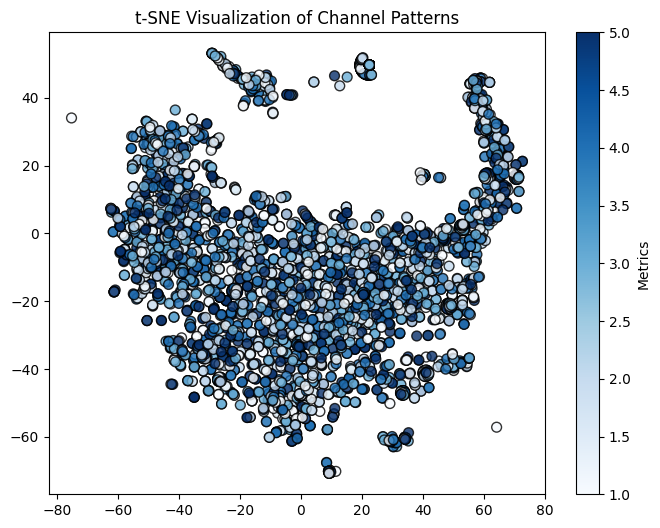

In [89]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib import cm


# inpe = batch_x[0].detach().cpu().numpy().transpose()

tsne = TSNE(n_components=2, random_state=42,perplexity=20)
low_dim_data = tsne.fit_transform(patch_inpe)
# plt.scatter(low_dim_data[:, 0], low_dim_data[:, 1], s=20, color='b')


# 示例数据
np.random.seed(42)
metrics = np.array(list(range(1, 6))*883) #np.random.randint(10, 100, size=50)  # 示例标准，随机生成50个值
# metrics = metrics[0:3000]
# 归一化标准值到[0, 1]范围
norm = Normalize(vmin=metrics.min(), vmax=metrics.max())
colors = cm.Blues(norm(metrics))  # 映射到蓝色渐变

# 绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(low_dim_data[:, 0], low_dim_data[:, 1], s=50, color=colors, edgecolors="k", alpha=0.8)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap="Blues"), label="Metrics")  # 添加颜色条
plt.title("t-SNE Visualization of Channel Patterns")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.grid()
plt.show()


/tmp/ipykernel_1214492/3538924331.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(norm=norm, cmap="Blues"), label="Time Step")  # 添加颜色条


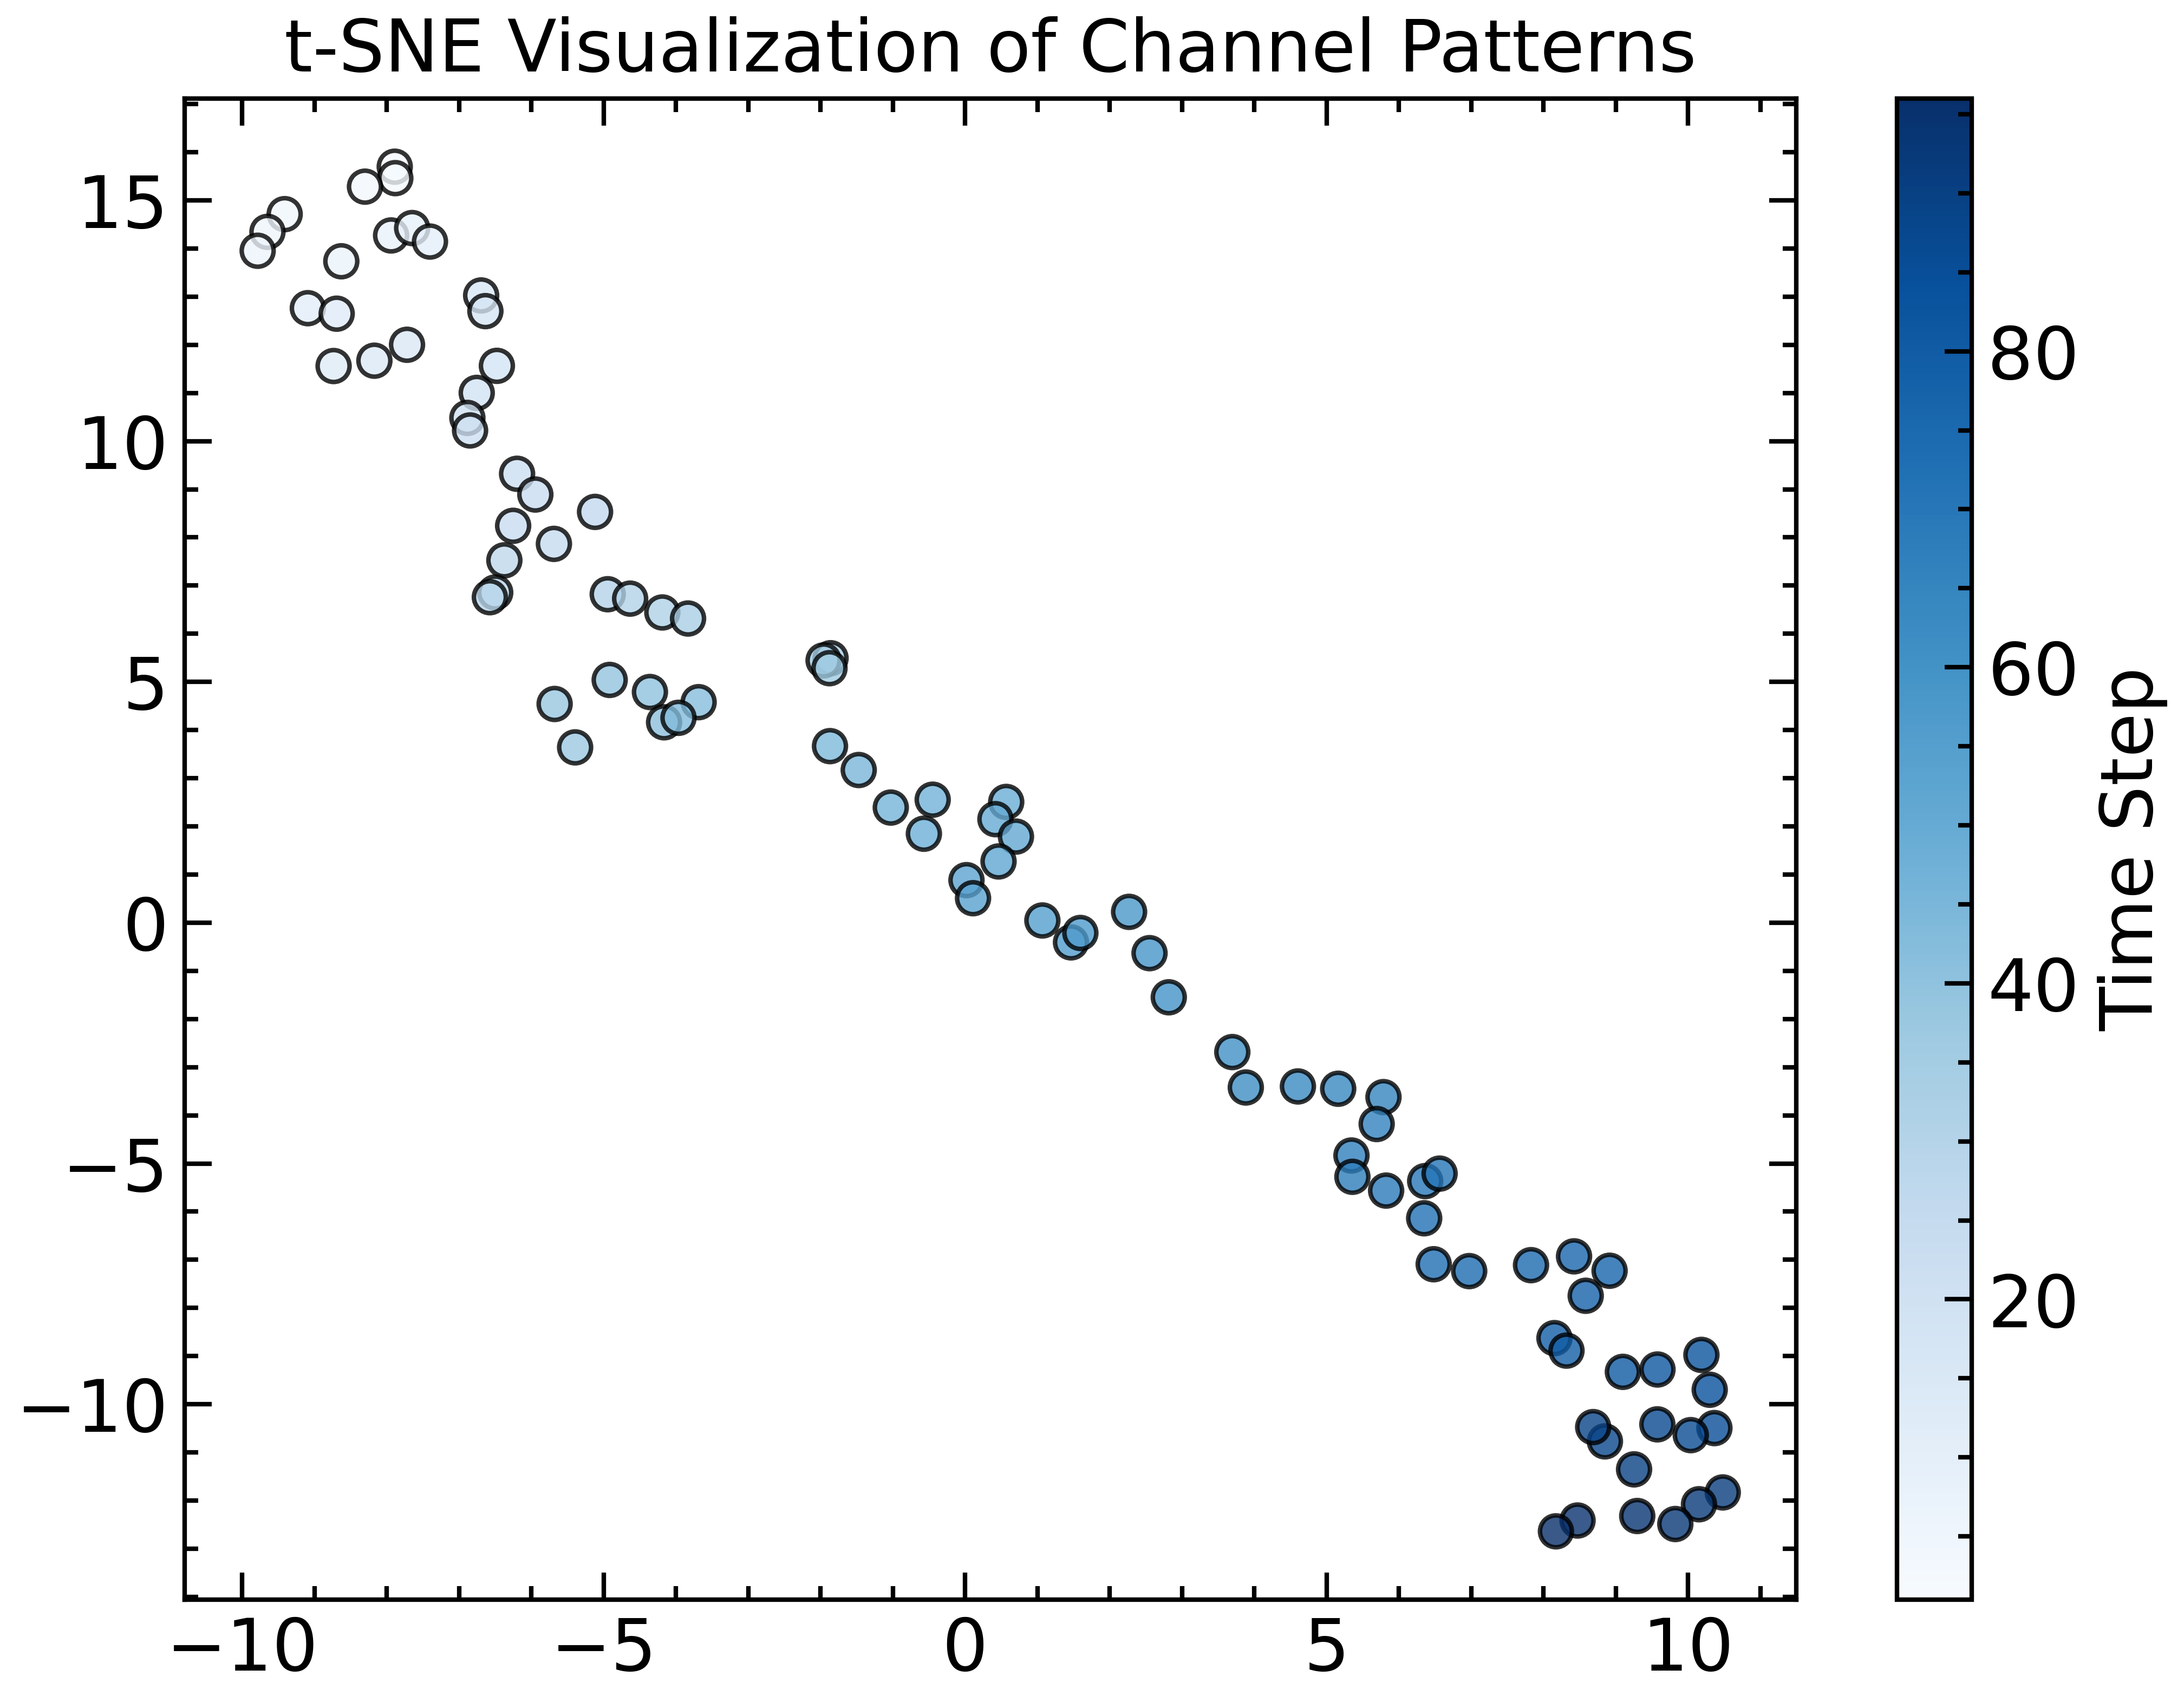

In [94]:
import scienceplots
plt.style.use(['science', 'ieee', 'notebook'])
inpe = batch_x[0].detach().cpu().numpy()
tsne = TSNE(n_components=2, random_state=42,perplexity=20)
low_dim_data = tsne.fit_transform(inpe)
# plt.scatter(low_dim_data[:, 0], low_dim_data[:, 1], s=20, color='b')
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib import cm

# 示例数据
np.random.seed(42)
metrics = np.array(list(range(1, 97)))#np.random.randint(10, 100, size=50)  # 示例标准，随机生成50个值

# 归一化标准值到[0, 1]范围
norm = Normalize(vmin=metrics.min(), vmax=metrics.max())
colors = cm.Blues(norm(metrics))  # 映射到蓝色渐变

# 绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(low_dim_data[:, 0], low_dim_data[:, 1], s=50, color=colors, edgecolors="k", alpha=0.8)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap="Blues"), label="Time Step")  # 添加颜色条
plt.title("t-SNE Visualization of Channel Patterns")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.grid()
plt.show()


Text(0.5, 1.0, 'CKA similarity With First Layer')

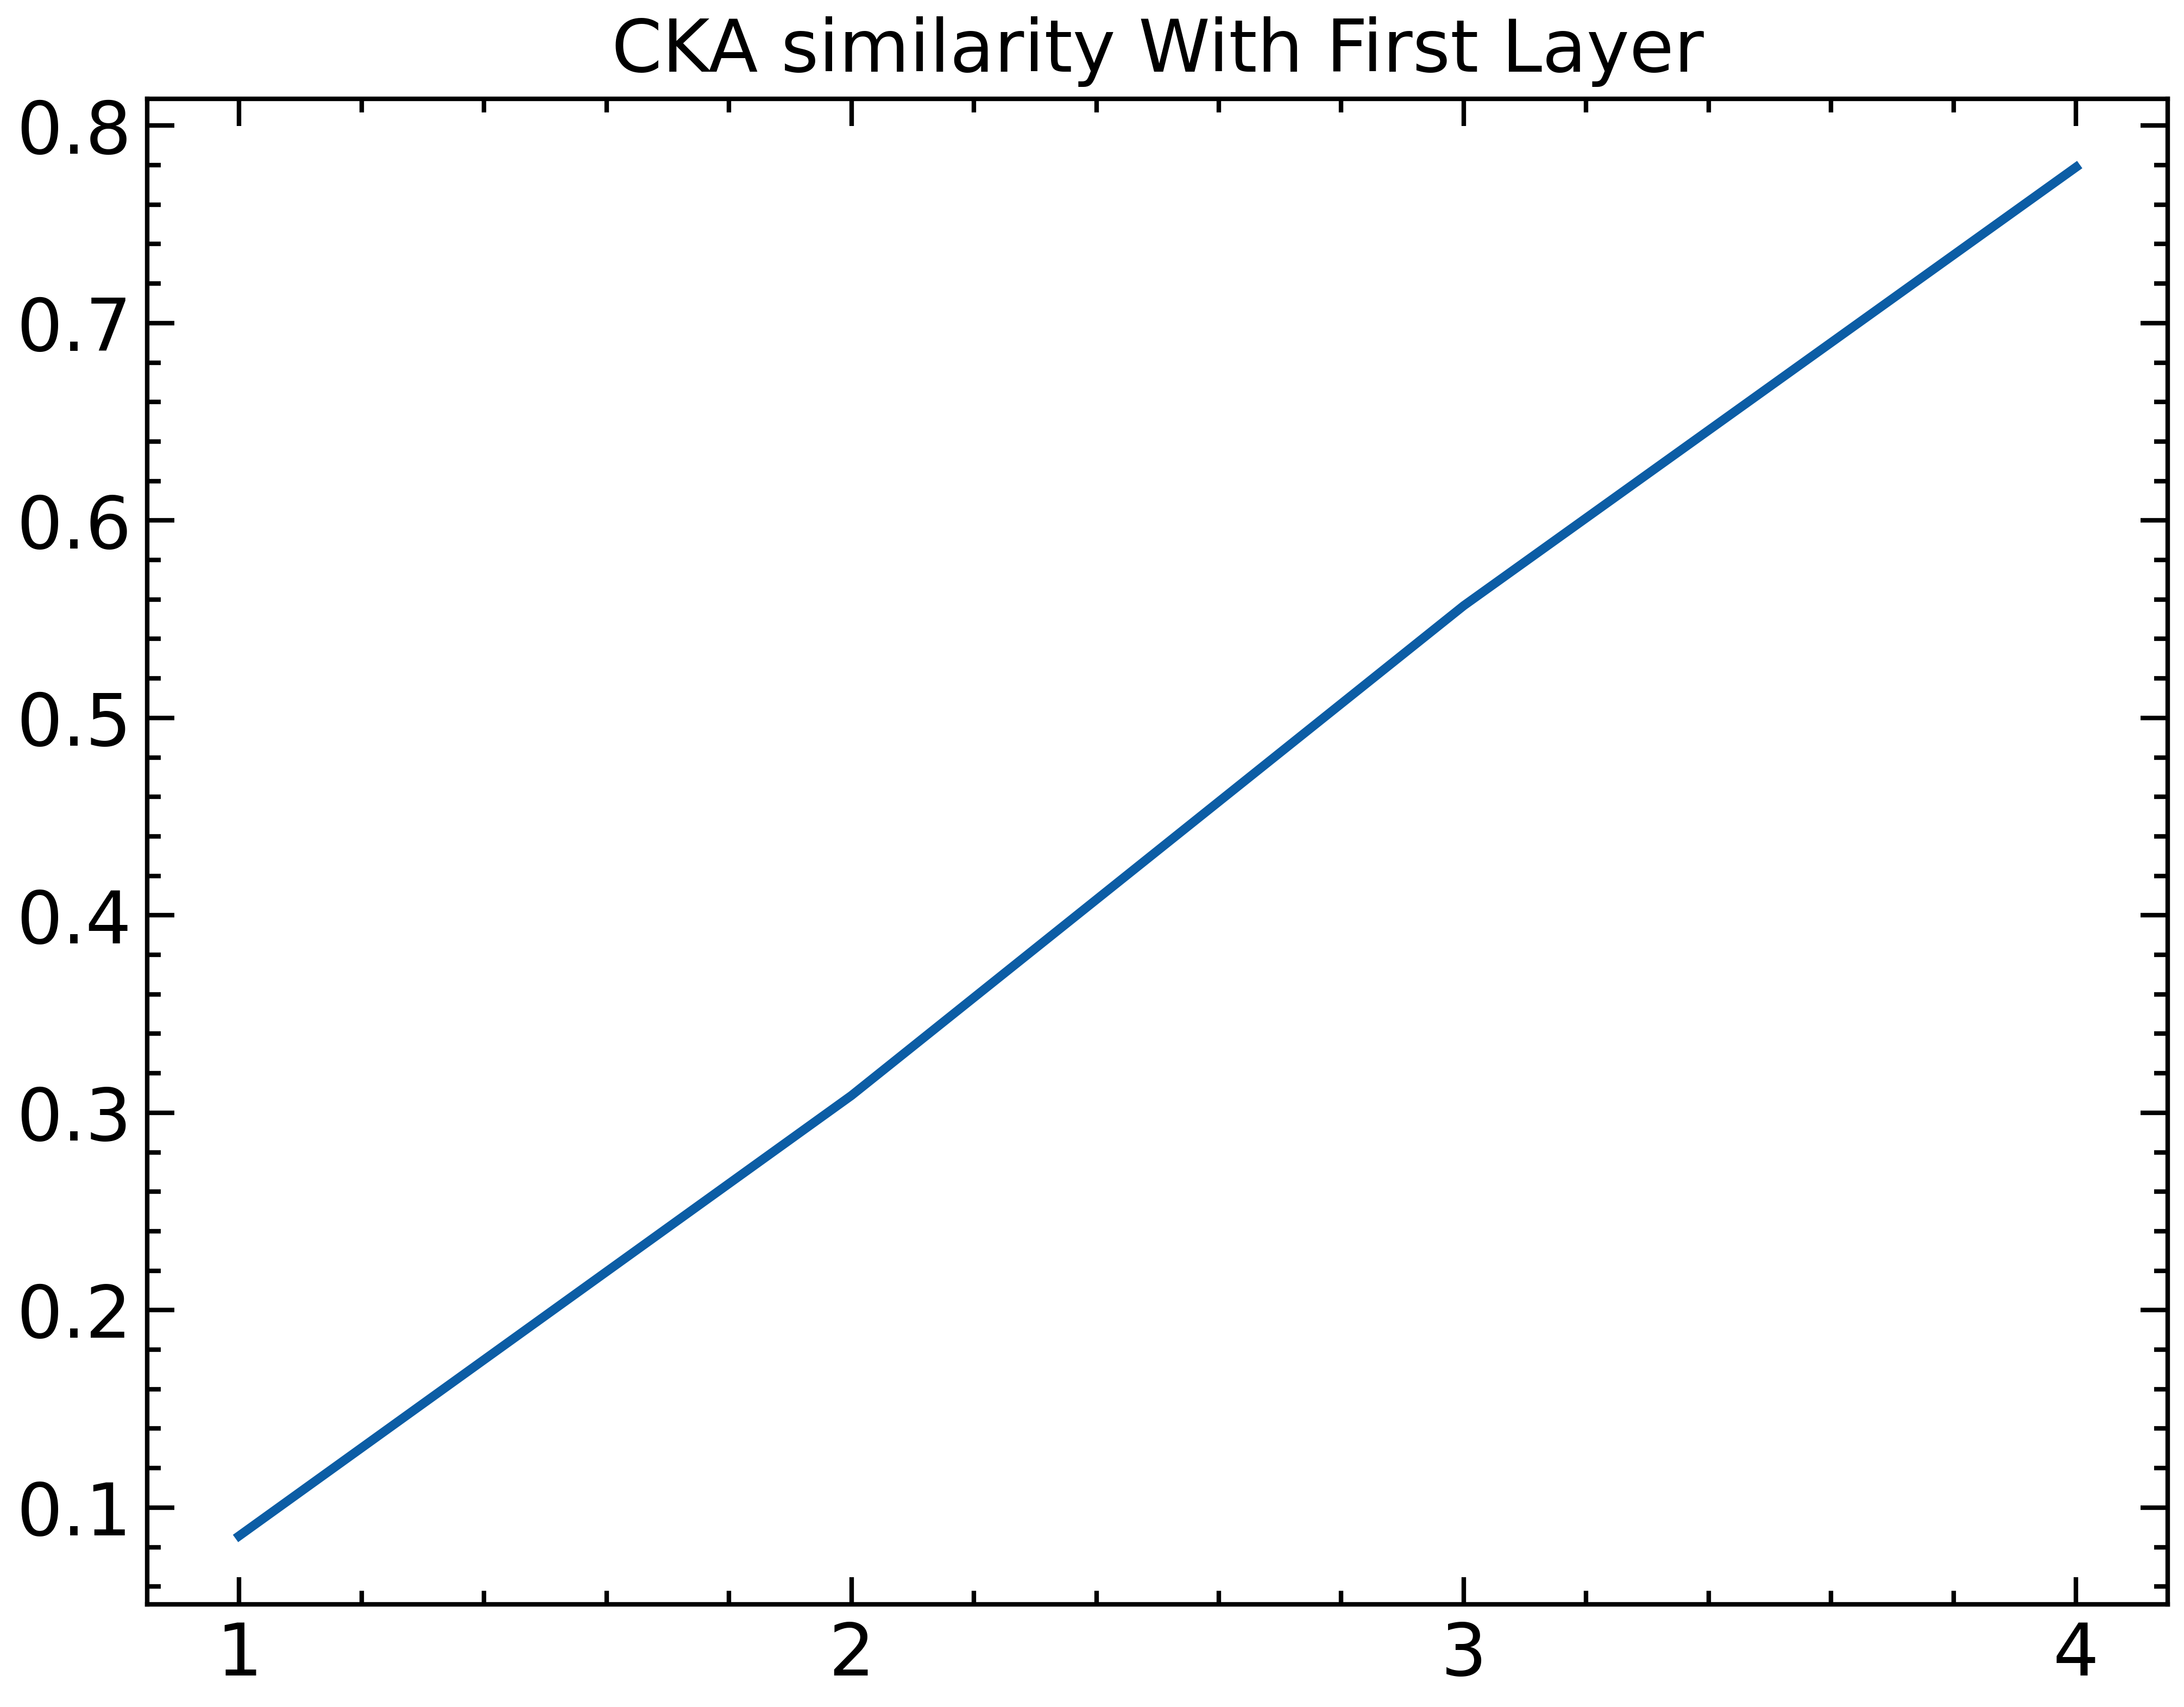

In [96]:
# gt = [0.08568580358090992, 0.10873463852040079, 0.25685810076329, 0.2789665560843655]
gt = [0.08568580358090992, 0.30873463852040079, 0.55685810076329, 0.7789665560843655]
f1 = [ 1.0 ,0.7200538591254788 , 0.2873470142431093 ,0.17574323965328137]

plt.style.use(['science', 'notebook'])
plt.plot([1,2,3,4], gt)
# plt.plot([1,2,3,4], f1)
plt.xticks([1,2,3,4])
plt.title('CKA similarity With Ground Truth')